[함수 정의] def 함수(매개변수)

[함수 호출] 함수(매개변수 = 인자)

### 지역변수, 전역변수

In [1]:
def test1():
    global x, y
    x *= 2
    y %= 2
    print(x, y)
    
x, y = 2,3
test1()

4 1


전역변수는 함수의 범위 밖에서도 쓰이는 변수다.

### 1. 프로젝트 함수화

#### 1-1 파일 읽기

In [2]:
# load library
import csv
from openpyxl import load_workbook as lw

def load_file():
    # 생활인구 데이터
    f = open("./data/LOCAL_PEOPLE_DONG_202206.csv", 
            encoding = 'utf8')
    data = csv.reader(f)
    next(data) # 컬럼명 제거
    data = list(data)

    # 행정동 코드 데이터
    code = lw("./data/행정동코드_매핑정보_20200325.xlsx", 
                            data_only = True) # 수식 제외 셀값만 가져오기

    # 행정동코드 시트의 데이터 가져오기
    code = code['행정동코드']

    # 행과 열의 데이터 출력 
    all_cell = []

    # code 데이터를 행 단위로 가져온다.
    for r in code.rows:
        r_value = [] # 빈 셀을 만든다

        # 행 단위로 가져온 데이터에서 셀값을 추출해 리스트에 담는다.
        for cell in r:
            r_value.append(cell.value)

        # 위의 과정을 반복하며 모든 데이터를 가져온다.
        all_cell.append(r_value)

    # 컬럼을 제외한다.
    code = all_cell[2:]
    
    # 위경도 데이터
    f2 = open("./data/서울시 행정동별 전력 사용량 2008년 위치정보 (좌표계_ WGS1984).csv", 
            encoding = 'cp949')
    where = csv.reader(f2)
    next(where) # 컬럼명 제거
    where = list(where)
    
    # 행정동 데이터 자료형 변환
    for row in data:
        for i in range(32):
            if i == 0 :
                row[i] = str(row[i])
            elif i <= 2 :
                row[i] = int(row[i])
            else :
                row[i] = float(row[i])

    # 코드 데이터 자료형 변환
    for row in code:
        row[1] = int(row[1])
        
    # 위경도 데이터 자료형 변환
    for row in where:
        row[2], row[-2], row[-1] = int(row[2]), float(row[-2]), float(row[-1])  
        
    return data, code, where

#### 1-2 동 이름과 코드 연결

In [3]:
def link_dong(dong):
    
    for row in code:
        if row[-1] == dong:
            dong_code = row[1]

    print(dong, "(" , dong_code , ")" + "을 살펴봅니다!")
    return dong_code

#### 1-3 꺾은선 그래프 함수 작성

In [4]:
import matplotlib.pyplot as plt

def linegraph(pop_list, label_list, title):
    plt.rc('font', family = "Malgun Gothic")
    plt.title(title, pad = 15)

    for i in range(len(pop_list)):
        plt.plot(range(24), pop_list[i], label = label_list[i])
        
    plt.xticks(range(24), range(24))
    plt.legend(loc = "best")
    plt.show()

#### 1-4 시간대별 인구 분석

In [5]:
def time_pop(dong, dong_code, make_line = 'y'):
    
    pop = [0 for i in range(24)]
    
    for row in data :
        if row[2] == dong_code:
            pop[row[1]] += row[3]

    pop = [i/31 for i in pop]
    
    if make_line == 'n':
        return pop
    
    pop = [pop]
    label = ['평균 생활인구']
    title = dong + " 시간대별 평균 생활인구"
    linegraph(pop, label, title)

#### 1-5 주중/말 분석 

In [6]:
import datetime as dt

def week_pop(dong, dong_code):
    
    weekday = [0 for i in range(24)]
    weekend = [0 for i in range(24)]

    for row in data:
        if row[2] == dong_code:
            if dt.date(int(row[0][:4]), int(row[0][4:6]), int(row[0][6:])).weekday() < 5:
                weekday[row[1]] += row[3]
            else :
                weekend[row[1]] += row[3]

    # 2021년 1월의 주중/주말 일수 구하기
    day_num, end_num = 0,0

    for i in range(1,32):
        if dt.date(2021,1,i).weekday() < 5:
            day_num +=1
        else:
            end_num +=1

    weekday = [w/day_num for w in weekday]
    weekend = [w/end_num for w in weekend]
    
    tar_data = [weekday, weekend]
    label = ['주중', '주말']
    title = dong + " 주중/말 평균 생활인구"
    linegraph(tar_data, label, title)

#### 1-6 성별 분석

In [7]:
def sex_pop(dong, dong_code):
    
    man = [0 for i in range(24)]
    woman = [0 for i in range(24)]

    for row in data:
        if row[2] == dong_code:
            man[row[1]] += sum(row[4:18])
            woman[row[1]] += sum(row[18:32])

    man = [m/31 for m in man]
    woman = [w/31 for w in woman]
    
    tar_data = [man, woman]
    label = ['남', '여']
    title = dong + " 성별 평균 생활인구"
    linegraph(tar_data, label, title)

#### 1-7 타 행정동과의 비교

In [8]:
def diff_pop(dong, dong_code):
    
    # 비교할 행정동 코드 찾기
    dong2 = input("비교할 행정동은? ==> ")
    dong_code2 = link_dong(dong2)
    
    # 두 지역의 평균 생활인구 구하기
    pop_a = time_pop(dong, dong_code, 'n')
    pop_b = time_pop(dong2, dong_code2, 'n')
    
    # 꺾은선 그래프 그리기
    tar_data = [pop_a, pop_b]
    label = [dong, dong2]
    title = dong + " & " + dong2 + " 시간대별 평균 생활인구"
    linegraph(tar_data, label, title)

#### 1-8 지도 만들기

In [9]:
import folium as fol
import operator as op

def topk_map(k):
      
    pop = {}

    for r in data:
        dong_code, p = r[2], r[3]

        if dong_code not in pop.keys():
            pop[dong_code] = p
        else :
            pop[dong_code] += p

    top = sorted(pop.items(), key = op.itemgetter(1), reverse = True)[:k]

    # 행정동 코드 저장
    top_code = [c[0] for c in top]
    
    top_name = [0 for i in range(k)]
    top_lat = [0 for i in range(k)]
    top_long = [0 for i in range(k)]

    for i in range(len(top)):
        
        # 행정동 이름
        for r in code:
            if r[1] == top_code[i]:
                top_name[i] = r[-1]   

        # 행정동 위경도
        for r in where:
            if r[3] == top_name[i]:
                top_lat[i], top_long[i] = r[-1], r[-2]

    for i in range(len(top_name)):
    
        # 위경도에 0인 데이터가 있으면
        if top_lat[i] == 0 or top_long[i] == 0 :

            # 7자리 행정동 코드 저장 
            for r in code:
                if top_code[i] == r[1]:
                    code7 = r[0]

            # 7자리 코드 위경도 구하기
            for r in where:
                if code7 == r[2]:
                    top_lat[i], top_long[i] = r[-1], r[-2]
        
    # 지도 그리기
    for i in range(len(top_code)):
        top_name[i] = str(i + 1) + '-' + top_name[i]
    
    topk_map = fol.Map([top_lat[0], top_long[0]], zoom_start = 10)

    for i in range(k):
        fol.Marker([top_lat[i], top_long[i]], tooltip = top_name[i],
              icon = fol.Icon(color = "purple", icon_color = "yellow", icon = "star",
                             prefix = 'fa')).add_to(topk_map)

    return topk_map

### 2. 함수 호출

찾으려는 행정동을 입력하세요! => 여의동
여의동 ( 11560540 )을 살펴봅니다!


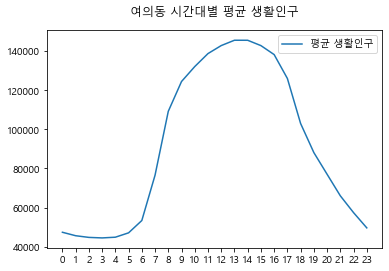

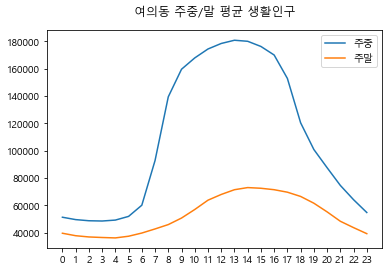

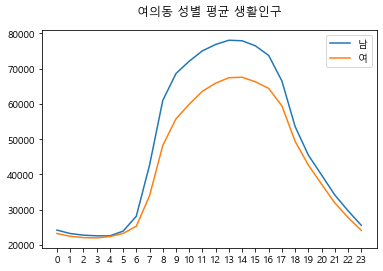

비교할 행정동은? ==> 역삼1동
역삼1동 ( 11680640 )을 살펴봅니다!


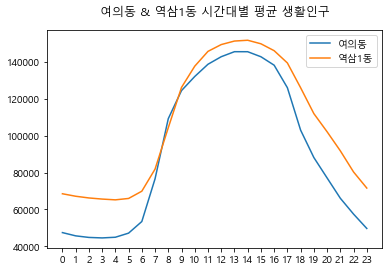

In [10]:
data, code, where = load_file()

tar_dong = input("찾으려는 행정동을 입력하세요! => ")
tar_code = link_dong(tar_dong)

# 하위분석1
time_pop(tar_dong, tar_code)

# 하위분석2
week_pop(tar_dong, tar_code)

# 하위분석3
sex_pop(tar_dong, tar_code)

# 하위분석4
diff_pop(tar_dong, tar_code)

# 하위분석5
topk_map(5)

### Self Check

#### 1

In [11]:
def dan19(num):
    for i in range(num, 20):
        print(num, "x" , i , "=" , num*i)

In [12]:
dan19(9)

9 x 9 = 81
9 x 10 = 90
9 x 11 = 99
9 x 12 = 108
9 x 13 = 117
9 x 14 = 126
9 x 15 = 135
9 x 16 = 144
9 x 17 = 153
9 x 18 = 162
9 x 19 = 171


#### 2

In [13]:
def dan19_all(a = 2, b = 20):
    for i in range(a, b):
        print(i, "단------")
        
        for j in range(1, 20):
            print(i, "x" , j , "=" , i*j)

In [14]:
dan19_all(3, 9)

3 단------
3 x 1 = 3
3 x 2 = 6
3 x 3 = 9
3 x 4 = 12
3 x 5 = 15
3 x 6 = 18
3 x 7 = 21
3 x 8 = 24
3 x 9 = 27
3 x 10 = 30
3 x 11 = 33
3 x 12 = 36
3 x 13 = 39
3 x 14 = 42
3 x 15 = 45
3 x 16 = 48
3 x 17 = 51
3 x 18 = 54
3 x 19 = 57
4 단------
4 x 1 = 4
4 x 2 = 8
4 x 3 = 12
4 x 4 = 16
4 x 5 = 20
4 x 6 = 24
4 x 7 = 28
4 x 8 = 32
4 x 9 = 36
4 x 10 = 40
4 x 11 = 44
4 x 12 = 48
4 x 13 = 52
4 x 14 = 56
4 x 15 = 60
4 x 16 = 64
4 x 17 = 68
4 x 18 = 72
4 x 19 = 76
5 단------
5 x 1 = 5
5 x 2 = 10
5 x 3 = 15
5 x 4 = 20
5 x 5 = 25
5 x 6 = 30
5 x 7 = 35
5 x 8 = 40
5 x 9 = 45
5 x 10 = 50
5 x 11 = 55
5 x 12 = 60
5 x 13 = 65
5 x 14 = 70
5 x 15 = 75
5 x 16 = 80
5 x 17 = 85
5 x 18 = 90
5 x 19 = 95
6 단------
6 x 1 = 6
6 x 2 = 12
6 x 3 = 18
6 x 4 = 24
6 x 5 = 30
6 x 6 = 36
6 x 7 = 42
6 x 8 = 48
6 x 9 = 54
6 x 10 = 60
6 x 11 = 66
6 x 12 = 72
6 x 13 = 78
6 x 14 = 84
6 x 15 = 90
6 x 16 = 96
6 x 17 = 102
6 x 18 = 108
6 x 19 = 114
7 단------
7 x 1 = 7
7 x 2 = 14
7 x 3 = 21
7 x 4 = 28
7 x 5 = 35
7 x 6 = 42
7 x 7 = 49
7 

In [15]:
def cal_grade(score):
    
    if score >= 80:
        return "A"
    elif score >= 40:
        return "B"
    else :
        return "C"

#### 3

In [ ]:
x = int(input("기말 점수 : "))
print("등급 :", cal_grade(x))